Sonification
=======

First, let's import dependencies:

In [1]:
%matplotlib notebook

import math
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import pygame

import sound_drivers.pa_tools as pa_tools
import sound_drivers.pg_tools as pg_tools
import sound_drivers.sc_tools as sc_tools

from synth import get_frequencies

Initialize audio:

In [2]:
pa_tools.init_audio()
pg_tools.init_audio()
sc_tools.init_audio()

2017-10-07 12:13:35,223 [acoustic_sight] [DEBUG] Initializing PyGame mixer...
2017-10-07 12:13:35,252 [acoustic_sight] [INFO] PyAudio initialized: <sound_drivers.pa_tools.PAState object at 0x1041b9898>
2017-10-07 12:13:35,253 [acoustic_sight] [DEBUG] Initializing PyGame mixer...
2017-10-07 12:13:35,427 [acoustic_sight] [INFO] PyGame mixer initialized: (88200, -16, 1)
2017-10-07 12:13:35,428 [acoustic_sight] [DEBUG] Starting SuperCollider server...
2017-10-07 12:13:35,819 [acoustic_sight] [INFO] SuperCollider server started: supriya.tools.servertools.Server(
    ip_address='127.0.0.1',
    port=57751,
    )


Play PyAudio sine wave at 440 Hz:

In [3]:
pa_440 = pa_tools.PAMultiTone([440.], .1)
pa_440.play()
time.sleep(1)
pa_440.stop()

Play PyGame sine wave at 440 Hz:

In [4]:
pg_440 = pg_tools.PGTone(440., .1)
pg_440.play(-1)
time.sleep(1)
pg_440.stop()

Play SuperCollider sine wave at 440 Hz:

In [5]:
sc_440 = sc_tools.SCTone(440., .1)
sc_440.play()
time.sleep(1)
sc_440.stop()

2017-10-07 12:13:54,614 [acoustic_sight] [DEBUG] Create dedicated SuperCollider tone group: supriya.tools.servertools.Group(
    children=(),
    )
2017-10-07 12:13:54,672 [acoustic_sight] [DEBUG] Pushed tone synth for 440.0 Hz to SuperColider server
2017-10-07 12:13:55,674 [acoustic_sight] [DEBUG] Released tone synth for 440.0 Hz from SuperColider server


Create signals:

<IPython.core.display.Javascript object>


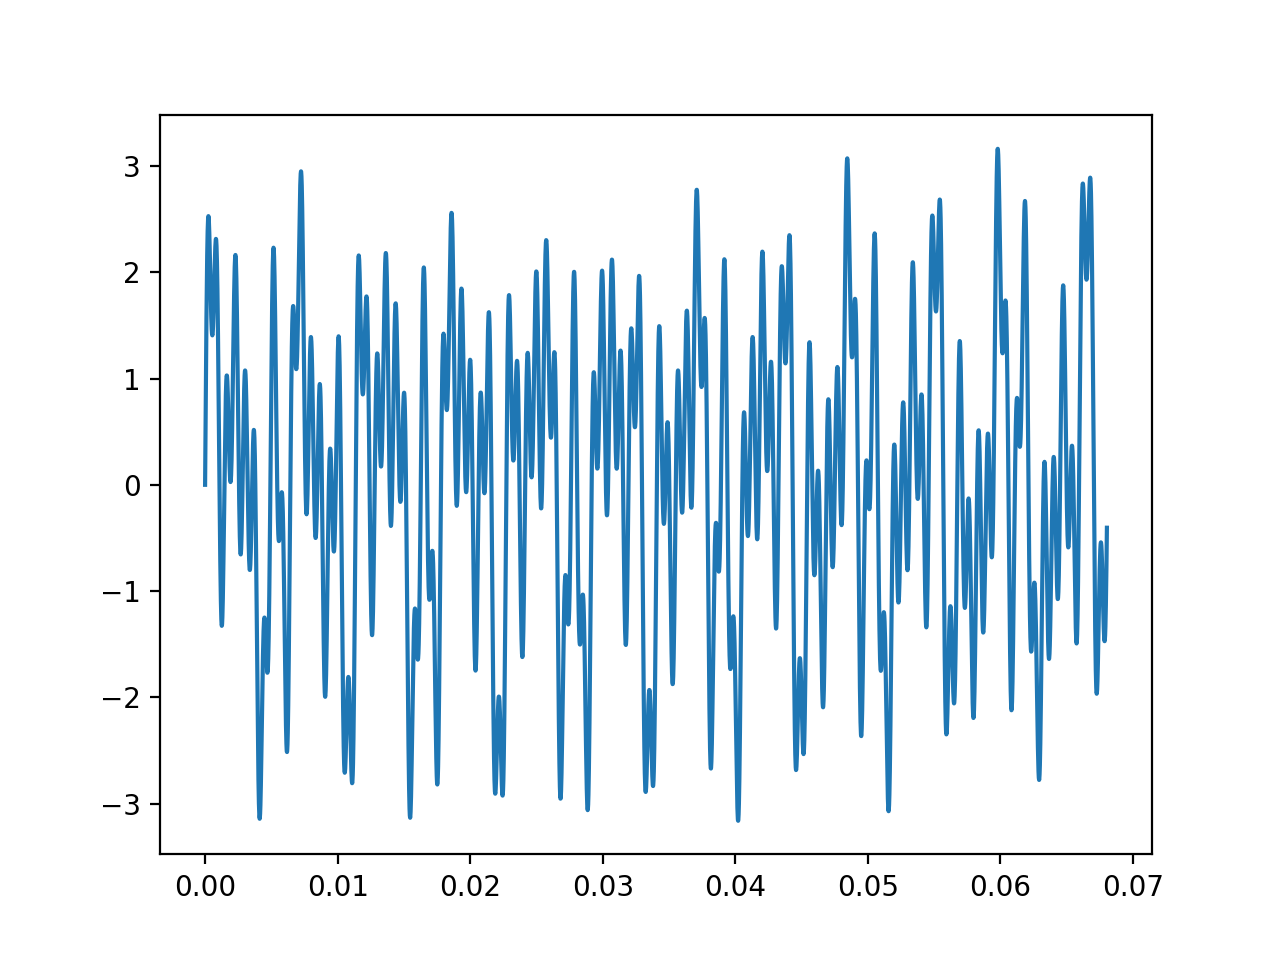

In [6]:
sample_rate = pygame.mixer.get_init()[0]
frame_size = 1500 * 4
frame_period = frame_size / sample_rate
time_vector = np.linspace(start=0, stop=frame_period, num=frame_size)

sin_440 = np.sin(time_vector * 2 * math.pi * 440)
sin_620 = np.sin(time_vector * 2 * math.pi * 620)
sin_170 = np.sin(time_vector * 2 * math.pi * 170)
sin_1410 = np.sin(time_vector * 2 * math.pi * 1410)

signal_components = 4
signal = sin_440 + sin_620 + sin_170 + sin_1410

plt.plot(time_vector, signal)

Play generated signal:

In [7]:
signal_pg = pygame.mixer.Sound((signal * pg_tools.get_max_amplitude() / signal_components).astype(np.int16))
signal_pg.play(-1)
time.sleep(1)
signal_pg.stop()

Pass signal through fast fourier transformation and then reconstract it back:

<IPython.core.display.Javascript object>


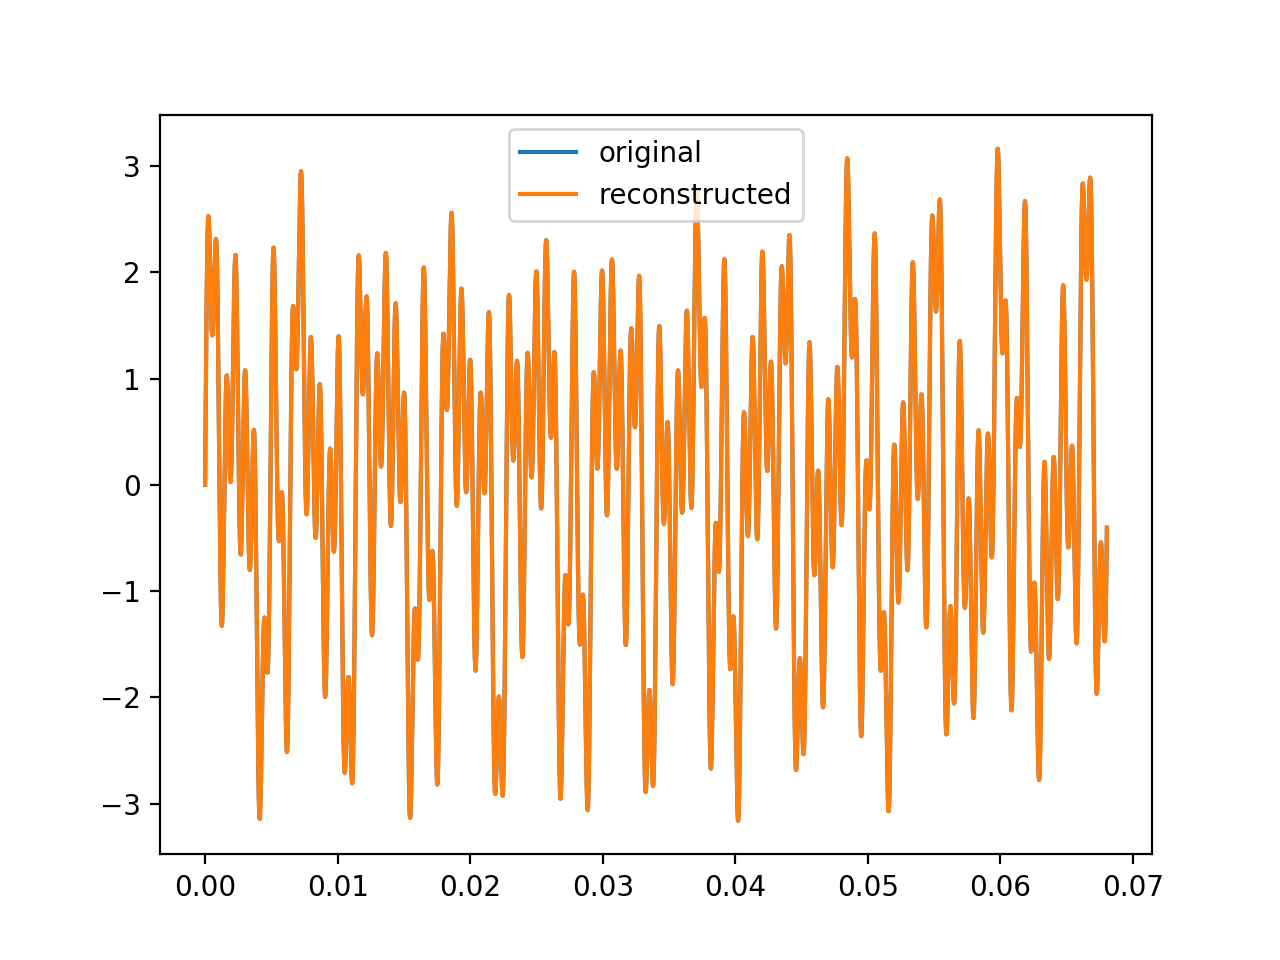

In [8]:
signal_rfft = fft.rfft(signal)
reconstructed_signal = fft.irfft(signal_rfft)
plt.plot(time_vector, signal)
plt.plot(time_vector, reconstructed_signal)
plt.legend(('original', 'reconstructed'))

Plot fast fourier transform representation of a signal:

<IPython.core.display.Javascript object>


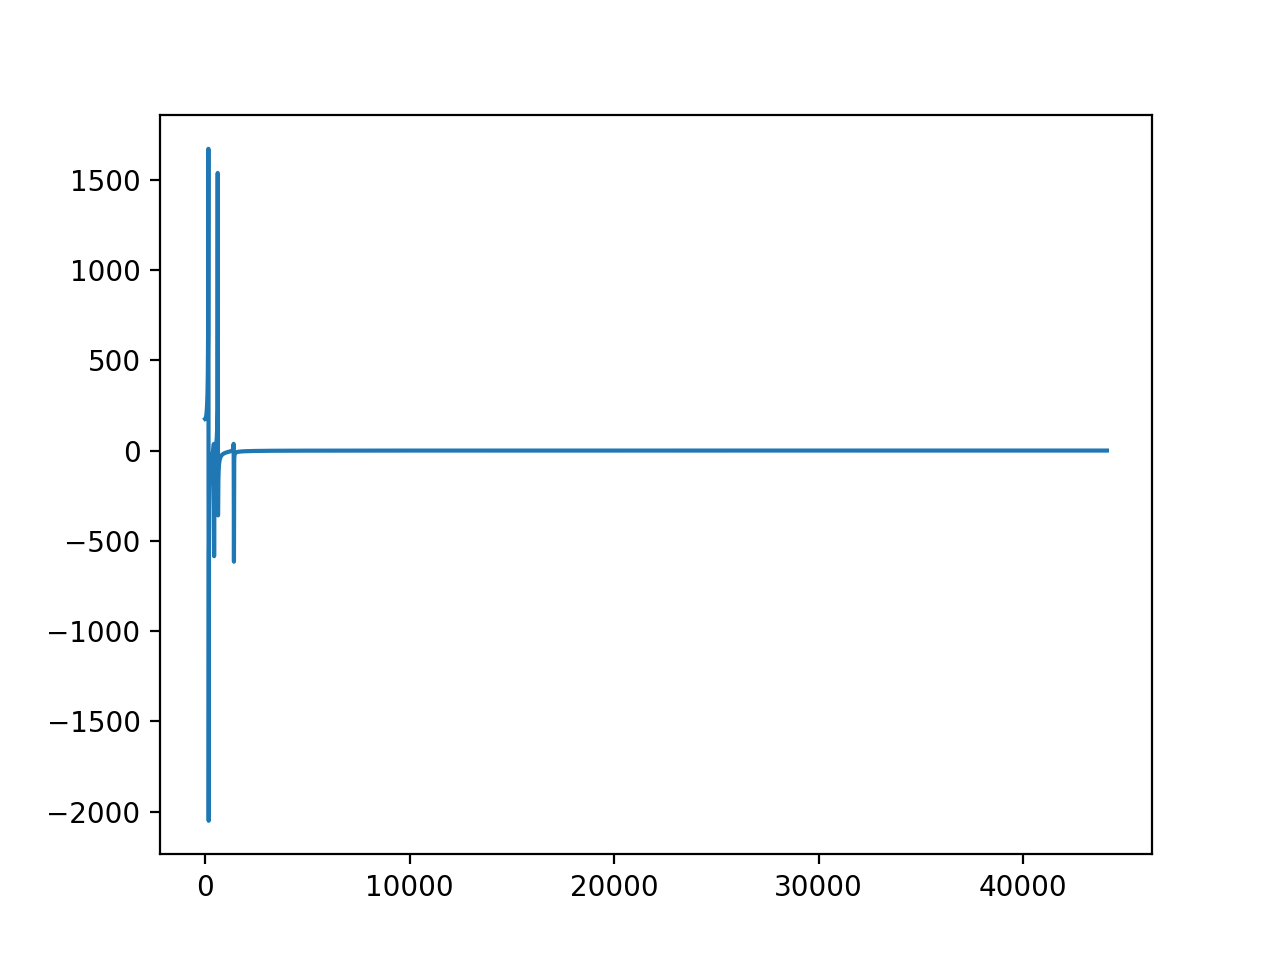

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [10]:
frequency_space = pa_tools.get_frequency_space(frame_size, sample_rate, fft_type=pa_tools.RFFT)
plt.plot(frequency_space, signal_rfft)

Reconstruct signal only from major frequence components:

<IPython.core.display.Javascript object>


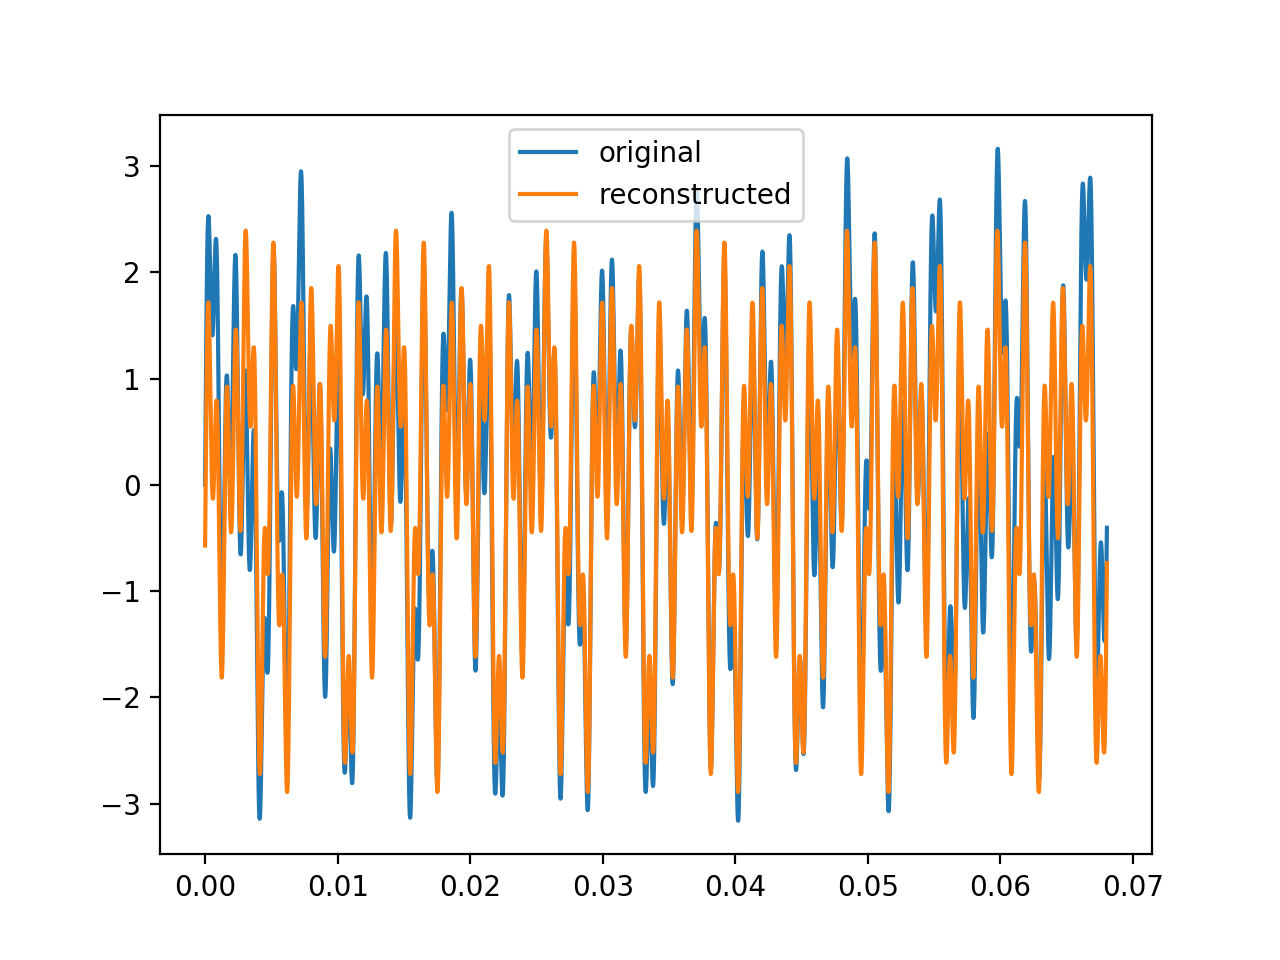

(array([30, 96, 42, 12]),
 array([  441. ,  1411.2,   617.4,   176.4]),
 array([ -584.98026681-2968.85154853j,  -615.43769425-2913.72803863j,
         1537.79985868-2396.07033492j, -2050.80104204 -455.58149225j]))

In [11]:
simplified_rfft = np.zeros(signal_rfft.size, dtype=signal_rfft.dtype)

top_idx, _, _ = pa_tools.get_top_frequencies(signal_rfft, frequency_space, signal_components)
for i in top_idx:
    simplified_rfft[i] = signal_rfft[i]

simplified_signal = fft.irfft(simplified_rfft, time_vector.size)

plt.plot(time_vector, signal)
plt.plot(time_vector, simplified_signal)
plt.legend(('original', 'reconstructed'))

pa_tools.get_top_frequencies(simplified_rfft, frequency_space, signal_components)

Plot fast fourier transform representation of a reconstructed signal:

<IPython.core.display.Javascript object>


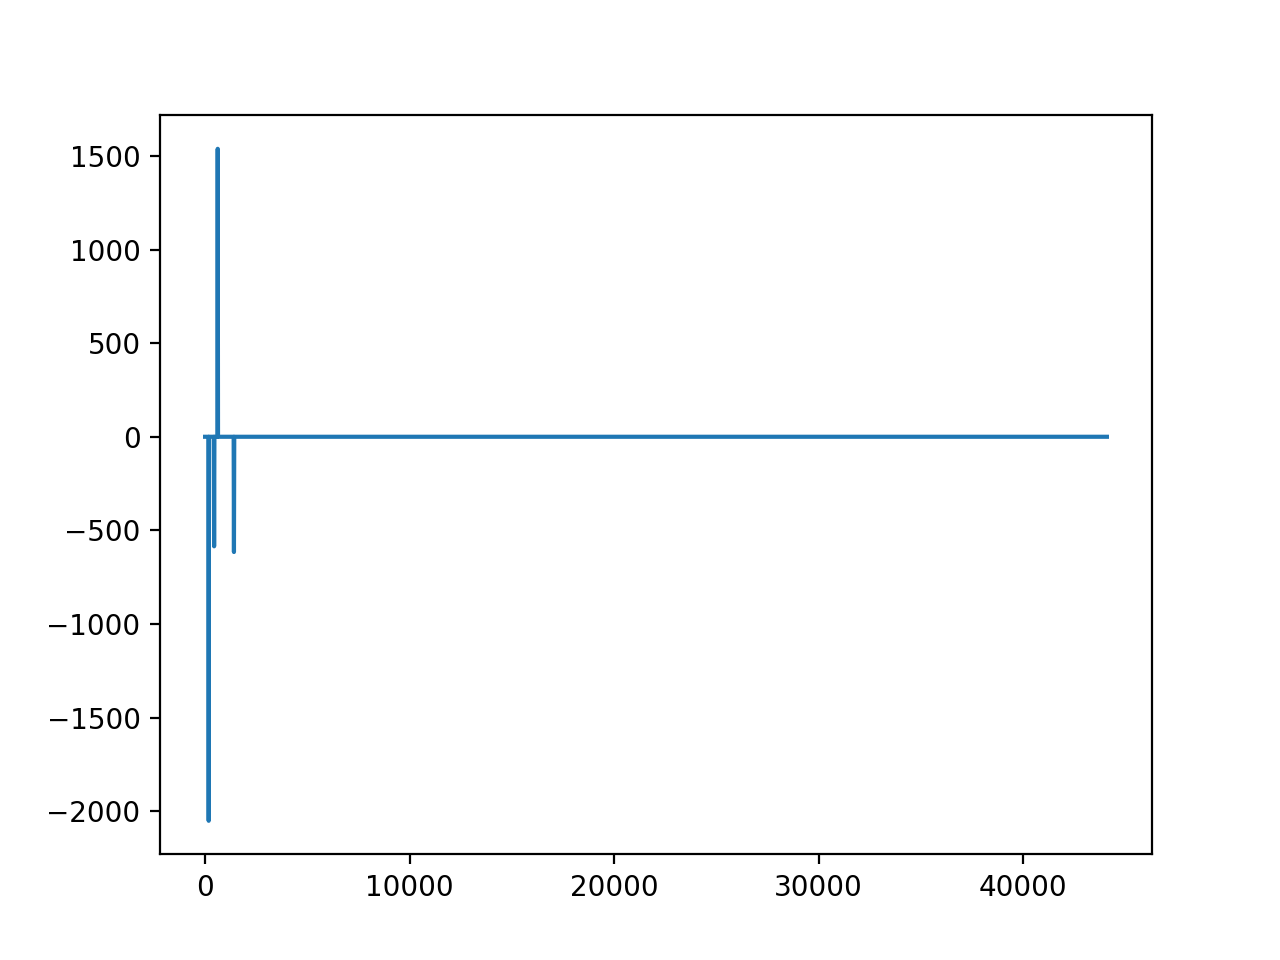

In [12]:
plt.plot(frequency_space, simplified_rfft.real)

Play reconstructed signal:

In [15]:
simplified_signal_pg = pygame.mixer.Sound((simplified_signal.real * pg_tools.get_max_amplitude() / signal_components).astype(np.int16))
simplified_signal_pg.play(-1)
time.sleep(1)
simplified_signal_pg.stop()

<IPython.core.display.Javascript object>


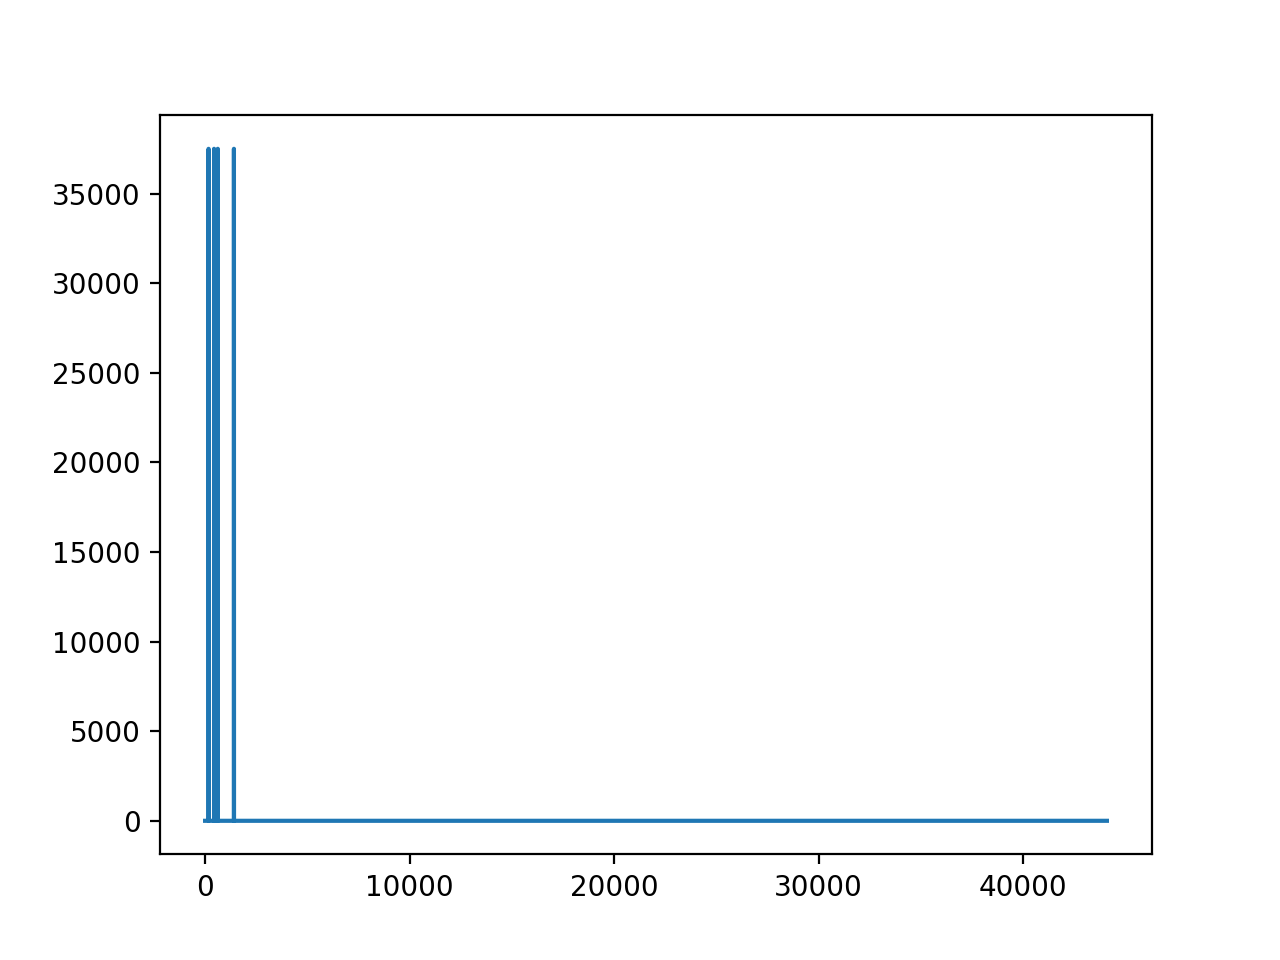

In [16]:
frame_size = 1500 * 4 * 25
levels = (2 ** 4) ** 2
octaves = 3
# frequencies = get_frequencies(octaves=octaves, levels=levels)
frequencies, levels, octaves = [170, 440, 620, 1410], 4, 3  # Reconstructed signal from previous examples

# amp_fn = lambda f: random.random() + random.random() * np.pi * 2 * 1j
amp_fn = lambda f: 1.
tones = [pa_tools.PATone(f, amp_fn(f)) for f in frequencies]

frequency_space = pa_tools.get_frequency_space(frame_size, sample_rate, fft_type=pa_tools.RFFT)
frequency_idx_map, _ = pa_tools.get_frequency_map(frequencies, frequency_space)

fs_signal = pa_tools.get_freq_space_signal(tones=tones,
                                           frequency_space=frequency_space,
                                           frequency_idx_map=frequency_idx_map,
                                           scale=frame_size / len(frequencies)
                                          )
signal = fft.irfft(fs_signal, frame_size)
scaled_signal = signal.real * pg_tools.get_max_amplitude() / 2

sound = pygame.mixer.Sound(scaled_signal.astype(np.int16))
sound.play(-1)
time.sleep(3)
sound.stop()

plt.plot(frequency_space, fs_signal.real)

# get_top_frequencies(rfft_sound, frequency_space, levels), frequences